### Imports

In [222]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re
import warnings
warnings.filterwarnings("ignore")

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from xgboost import XGBClassifier
from sklearn.metrics import classification_report, roc_curve
from imblearn.over_sampling import SMOTE
import shap

### Dataset loading and basic cleaning

In [223]:
clients = pd.read_excel("btUTgX.xlsx", index_col=0)

In [224]:
clients = clients[clients['tenure'] != 0]  # remove new customers
clients['TotalCharges'] = pd.to_numeric(clients['TotalCharges'], errors='coerce')
clients = clients.dropna(subset=['TotalCharges'])

In [225]:
# print how many No and Yes in Churn in the whole dataset
print("Churn distribution in the whole dataset:")
print(clients['Churn'].value_counts())

Churn distribution in the whole dataset:
Churn
No     5163
Yes    1869
Name: count, dtype: int64


In [226]:
def convert_boolean_variables(df: pd.DataFrame) -> pd.DataFrame:
    """
    Convert all categorical variables with two possible values into booleans.
    Takes and returns a dataframe
    """

    new_df = df.copy()

    for i, col in enumerate(list(df.columns)):
        if list(df.dtypes)[i] == "object":
            values = list(set(df[col]))
            if len(values) == 2:
                # Convert the text into boolean
                new_df[col] = new_df[col].apply(lambda x: 1 if x==values[0] else 0)
    
    return new_df

clients = convert_boolean_variables(clients)

### Feature Engineering

Additional features:
- InternetSecurity: combines OnlineSecurity and OnlineBackup (1 if any is Yes)
- Streaming: combines StreamingTV and StreamingMovies (1 if any is Yes)
- HouseholdComplexity: number of 'Yes' in Partner and Dependents (0 to 2)
- ChargesDiscrepancy: expected charges vs actual (MonthlyCharges * Tenure - TotalCharges)
- ContractStability: encodes contract length as ordinal
- TechSupport_InternetSecurity: 1 if either TechSupport or InternetSecurity is active
- Senior: remaps SeniorCitizen binary to Yes/No for readability (encoded later)

In [227]:
def simplify_services(df):
    df["InternetSecurity"] = df[["OnlineSecurity", "OnlineBackup"]].apply(lambda row: 'Yes' if 'Yes' in row.values else 'No', axis=1)
    df["Streaming"] = df[["StreamingTV", "StreamingMovies"]].apply(lambda row: 'Yes' if 'Yes' in row.values else 'No', axis=1)
    df["HouseholdComplexity"] = (np.sum(df[["Partner", "Dependents"]].to_numpy(), axis = 1) > 0).astype(int)
    df["ChargesDiscrepancy"] = df["MonthlyCharges"] * df["tenure"] - df["TotalCharges"]
    df["ContractStability"] = df["Contract"].map({"Month-to-month": 0, "One year": 1, "Two year": 2})
    df["TechSupport_InternetSecurity"] = df[["TechSupport", "InternetSecurity"]].apply(lambda x: 'Yes' if 'Yes' in x.values else 'No', axis=1)
    df["Senior"] = df["SeniorCitizen"].map({1: "Yes", 0: "No"})
    return df

clients = simplify_services(clients)

In [228]:
# Bin continuous features
clients["MonthlyChargesBin"] = pd.cut(clients["MonthlyCharges"], bins=[0, 35, 70, 105, 140], labels=False)
clients["TenureBin"] = pd.cut(clients["tenure"], bins=[0, 12, 24, 48, 72], labels=False)

### Feature Encoding

In [229]:
def convert_boolean_variables(df):
    for col in df.columns:
        if df[col].nunique() == 2 and df[col].dtype == object:
            df[col] = df[col].map({'Yes': 1, 'No': 0})
    return df

clients = convert_boolean_variables(clients)
clients = pd.get_dummies(clients, drop_first=True)

### Visualizations

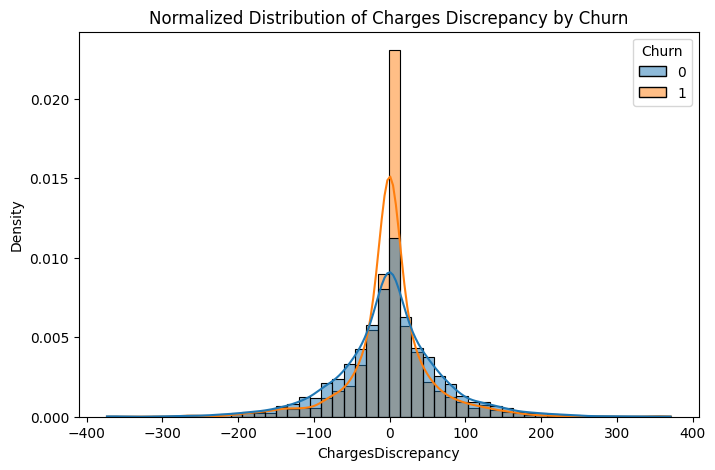

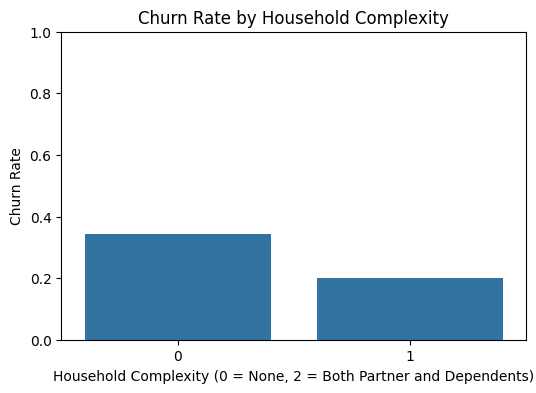

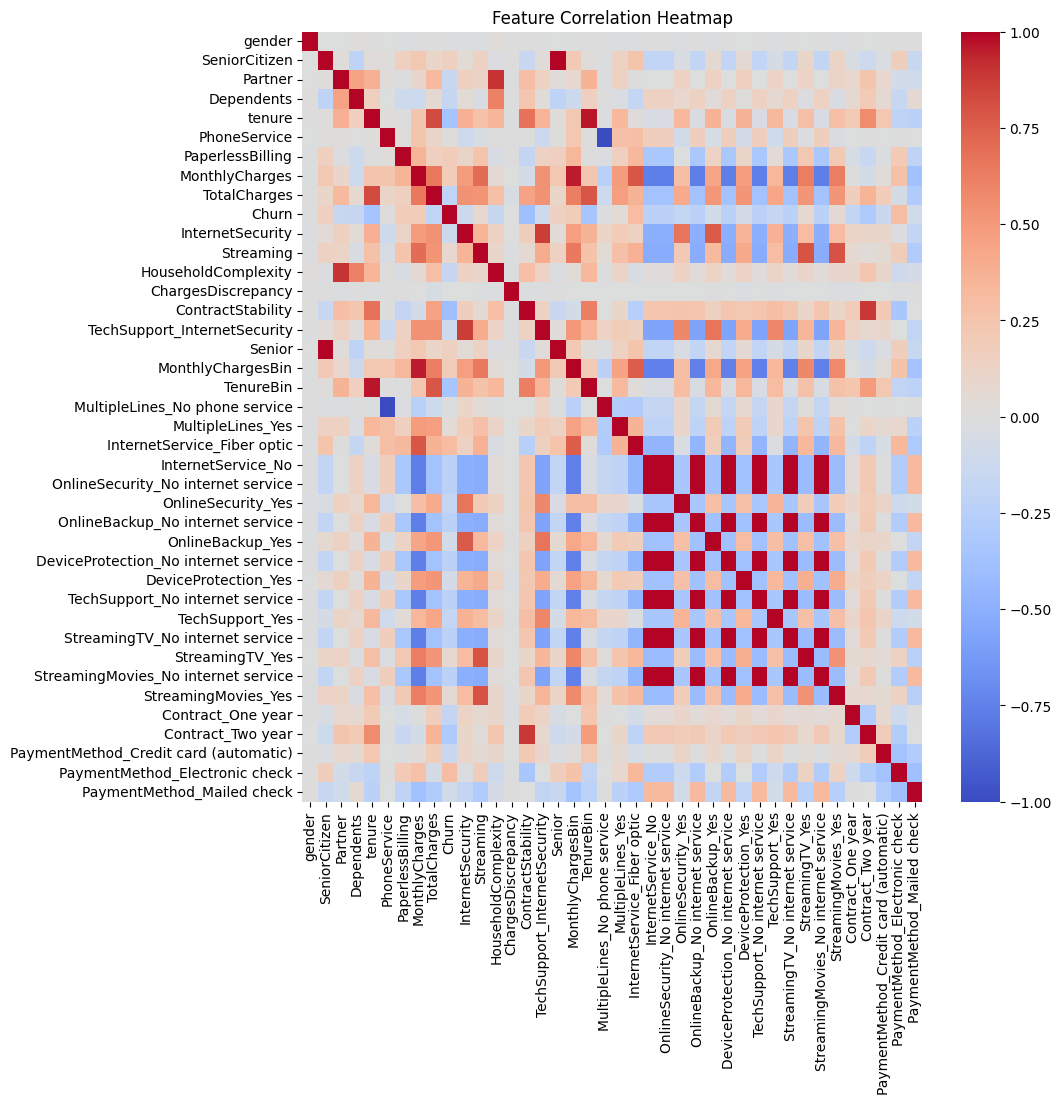

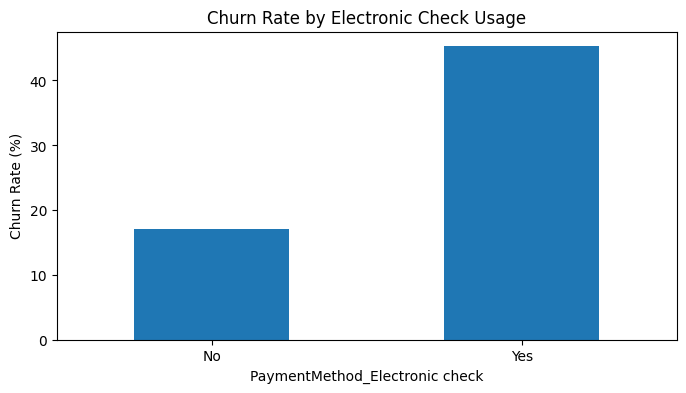


Churn rate by ContractStability:
ContractStability
0    0.427097
1    0.112772
2    0.028487
Name: Churn, dtype: float64


In [230]:
plt.figure(figsize=(8, 5))
sns.histplot(data=clients, x="ChargesDiscrepancy", hue="Churn", kde=True, bins=50, stat="density", common_norm=False)
plt.title("Normalized Distribution of Charges Discrepancy by Churn")
plt.show()

plt.figure(figsize=(6, 4))
complexity_churn_rate = clients.groupby("HouseholdComplexity")["Churn"].mean()
sns.barplot(x=complexity_churn_rate.index, y=complexity_churn_rate.values)
plt.xlabel("Household Complexity (0 = None, 2 = Both Partner and Dependents)")
plt.ylabel("Churn Rate")
plt.title("Churn Rate by Household Complexity")
plt.ylim(0, 1)
plt.show()

plt.figure(figsize=(10, 10))
sns.heatmap(clients.corr(numeric_only=True), cmap="coolwarm", center=0)
plt.title("Feature Correlation Heatmap")
plt.show()

plt.figure(figsize=(8, 4))
churn_pct_by_payment = clients.groupby("PaymentMethod_Electronic check")["Churn"].mean() * 100
churn_pct_by_payment.plot(kind='bar')
plt.ylabel("Churn Rate (%)")
plt.title("Churn Rate by Electronic Check Usage")
plt.xticks([0, 1], ["No", "Yes"], rotation=0)
plt.show()

# Churn percentage by Contract
churn_by_contract = clients.groupby("ContractStability")["Churn"].mean()
print("\nChurn rate by ContractStability:")
print(churn_by_contract)

### Train, Dev, Test Dataset

In [231]:
y = clients['Churn']
X = clients.drop(columns=['Churn'])
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.3, stratify=y, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, stratify=y_temp, random_state=42)

### Address Class Imbalance

In [232]:
print(f"Imbalance ratio (No:Yes): {round(sum(y_train==0)/sum(y_train==1), 2)}:1")
print(f"Original training shape: {X_train.shape}")

sm = SMOTE(random_state=0)
X_train_res, y_train_res = sm.fit_resample(X_train, y_train)
print(f"Resampled shape: {X_train_res.shape}")

Imbalance ratio (No:Yes): 2.76:1
Original training shape: (4922, 39)
Resampled shape: (7228, 39)


### Train Models

In [233]:
def plot_feat_imp(feat_imp, k=10):
    """"
    Plot the top k feature importances of a model"
    """

    # Get 10 highest feature importances and corresponing column names
    feat_top = np.argsort(abs(feat_imp))[-10:]
    col_names = [X_train.columns[i] for i in feat_top]

    # plot absolute feature importances
    plt.figure(figsize=(7, 5))
    plt.barh(col_names, feat_imp[feat_top])
    plt.xlabel("Feature importance")
    plt.ylabel("Feature")

def round2(x):
    return round(x, 2)

In [ ]:
# Perform grid search for logistic regression on the oversampled dataset
log_reg = LogisticRegression(max_iter=1000)
param_grid = {
    'C': [0.01, 0.1, 1, 10, 100],
    'penalty': ['l1', 'l2'],
    'solver': ['liblinear']
}
grid_search_lg = GridSearchCV(log_reg, param_grid, cv=5, scoring='f1', n_jobs=-1)
grid_search_lg.fit(X_train_res, y_train_res)

# Print the best parameters and the corresponding score
print("Best parameters:", grid_search_lg.best_params_)
print("Best F1 score:", grid_search_lg.best_score_)

              precision    recall  f1-score   support

           0       0.84      0.88      0.86       775
           1       0.61      0.53      0.57       280

    accuracy                           0.79      1055
   macro avg       0.72      0.70      0.71      1055
weighted avg       0.78      0.79      0.78      1055



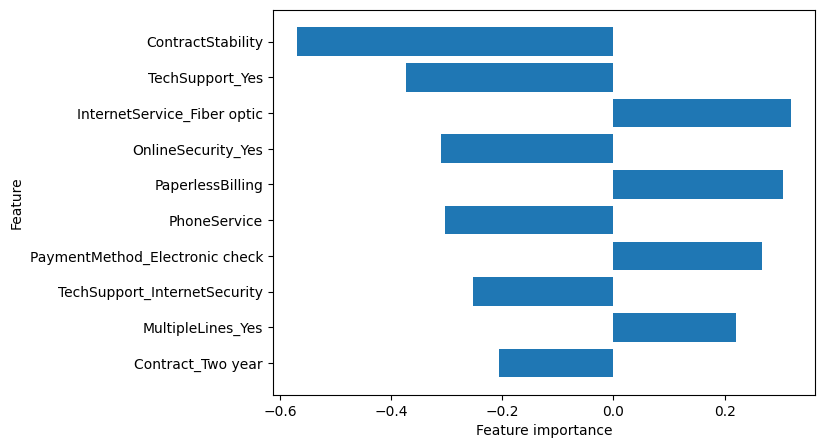

In [235]:
# Logistic regression with best parameters from grid search
best_params = grid_search_lg.best_params_
logistic_model = LogisticRegression(max_iter=1000, **best_params)
logistic_model.fit(X_train, y_train)
y_pred = logistic_model.predict(X_test)

print(classification_report(y_test, y_pred))
plot_feat_imp(logistic_model.coef_[0])

In [ ]:
# Perform grid search for random forest on the oversampled dataset
rf = RandomForestClassifier(random_state=42)
param_grid = {
    'n_estimators': [50, 100, 200],
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}
grid_search_rf = GridSearchCV(rf, param_grid, cv=5, scoring='f1', n_jobs=-1)
grid_search_rf.fit(X_train_res, y_train_res)
# Print the best parameters and the corresponding score
print("Best parameters:", grid_search_rf.best_params_)
print("Best F1 score:", grid_search_rf.best_score_)

Random Forest Performance:
               precision    recall  f1-score   support

           0       0.86      0.86      0.86       774
           1       0.61      0.60      0.61       281

    accuracy                           0.79      1055
   macro avg       0.73      0.73      0.73      1055
weighted avg       0.79      0.79      0.79      1055



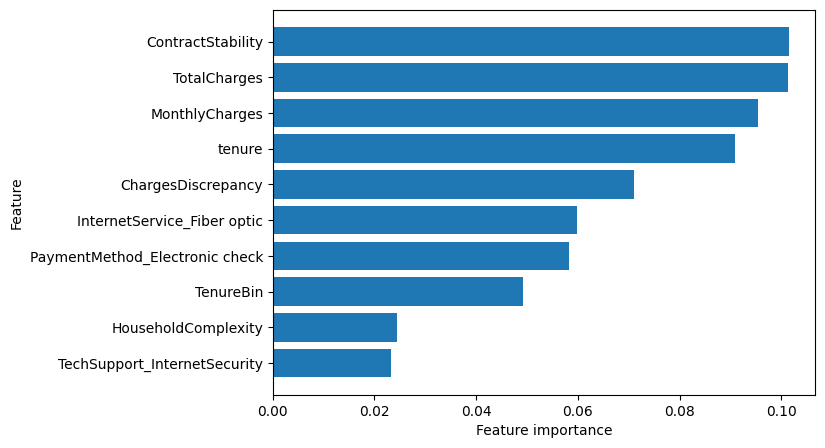

In [237]:
# Random Forest Classifier

rf_model = RandomForestClassifier(random_state=42)
rf_model.fit(X_train_res, y_train_res)
y_pred_rf = rf_model.predict(X_val)
print("Random Forest Performance:\n", classification_report(y_val, y_pred_rf))
plot_feat_imp(rf_model.feature_importances_)

In [ ]:
# Perform grid search for xgboost on the oversampled dataset
xgb = XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42)
param_grid = {
    'n_estimators': [50, 100, 200],
    'max_depth': [3, 5, 7],
    'learning_rate': [0.01, 0.1, 0.2],
    'subsample': [0.8, 1.0]
}
grid_search_xgb = GridSearchCV(xgb, param_grid, cv=5, scoring='f1', n_jobs=-1)
grid_search_xgb.fit(X_train_res, y_train_res)
# Print the best parameters and the corresponding score
print("Best parameters:", grid_search_xgb.best_params_)
print("Best F1 score:", grid_search_xgb.best_score_)

XGBoost Performance:
               precision    recall  f1-score   support

           0       0.86      0.85      0.85       774
           1       0.60      0.63      0.61       281

    accuracy                           0.79      1055
   macro avg       0.73      0.74      0.73      1055
weighted avg       0.79      0.79      0.79      1055



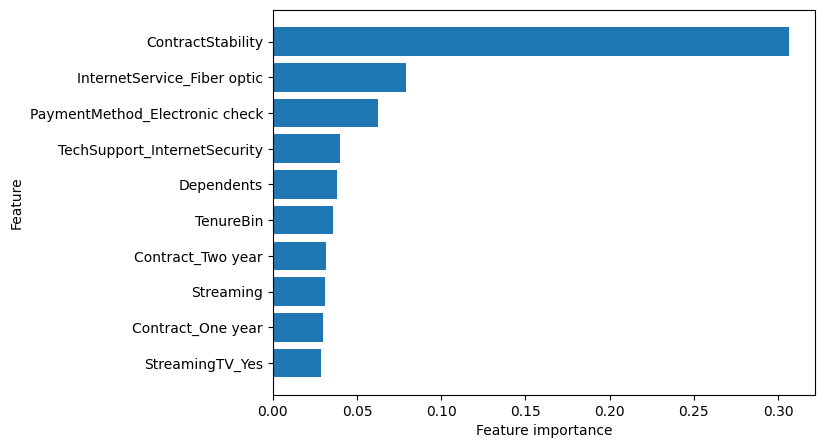

In [239]:
# XGBoost Classifier
best_params_xgb = grid_search_xgb.best_params_
xgb_model = XGBClassifier(**best_params_xgb, random_state=42, use_label_encoder=False, eval_metric='logloss')
xgb_model.fit(X_train_res, y_train_res)
y_pred_xgb = xgb_model.predict(X_val)
print("XGBoost Performance:\n", classification_report(y_val, y_pred_xgb))
plot_feat_imp(xgb_model.feature_importances_)

### Feature Importance analysis for XGBoost

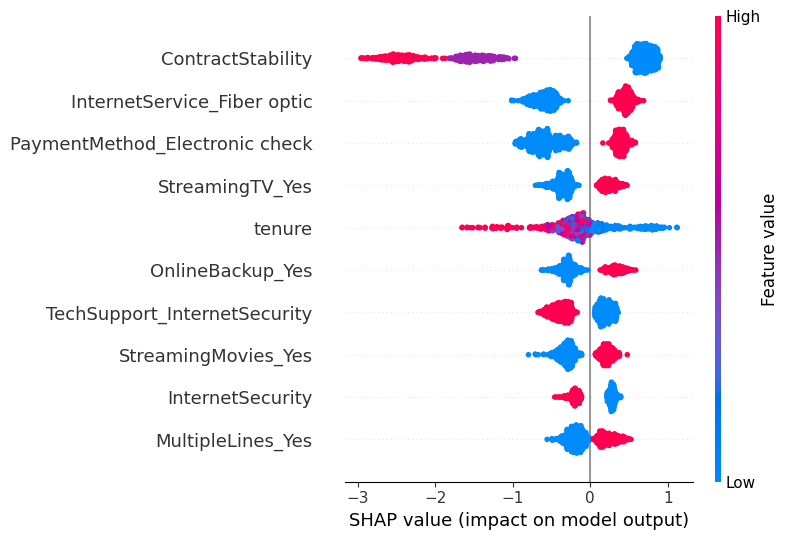

In [240]:
explainer = shap.Explainer(xgb_model)
shap_values = explainer(X_val)
shap.summary_plot(shap_values, X_val, max_display=10)

### Business Insights: Lift Analysis

In [241]:
y_proba = xgb_model.predict_proba(X_val)[:, 1]
val_df = pd.DataFrame({"proba": y_proba, "true": y_val.values})
val_df = val_df.sort_values("proba", ascending=False).reset_index(drop=True)

# Optimal threshold tuning (maximize F1-score or net benefit)
fpr, tpr, thresholds = roc_curve(y_val, y_proba)
gmeans = np.sqrt(tpr * (1 - fpr))
ix = np.argmax(gmeans)
threshold = thresholds[ix]
print(f"\nOptimal threshold based on G-Mean: {threshold:.2f}")

val_df["pred"] = (val_df["proba"] > threshold).astype(int)

# Cost assumptions
retention_cost = 10
churn_cost = 250

FP = ((val_df["pred"] == 1) & (val_df["true"] == 0)).sum()
FN = ((val_df["pred"] == 0) & (val_df["true"] == 1)).sum()
TP = ((val_df["pred"] == 1) & (val_df["true"] == 1)).sum()

false_positive_cost = FP * retention_cost
false_negative_cost = FN * churn_cost
true_positive_value = TP * churn_cost

net_benefit = true_positive_value - false_positive_cost - false_negative_cost
print("\nBusiness Impact (at optimal threshold):")
print(f"Cost of unnecessary retention actions: ${false_positive_cost}")
print(f"Cost of missed churns: ${false_negative_cost}")
print(f"Value of prevented churns: ${true_positive_value}")
print(f"Net benefit: ${net_benefit}")

# Lift analysis
print("\nXGBoost Lift Analysis on Validation Set:")
quantiles = [0.1, 0.2, 0.3, 0.4, 0.5]
base_rate = val_df["true"].mean()

for q in quantiles:
    top_k = val_df.iloc[:int(len(val_df)*q)]
    lift = top_k["true"].mean() / base_rate
    print(f"Lift at top {int(q*100)}%: {lift:.2f}x")


Optimal threshold based on G-Mean: 0.31

Business Impact (at optimal threshold):
Cost of unnecessary retention actions: $2020
Cost of missed churns: $15500
Value of prevented churns: $54750
Net benefit: $37230

XGBoost Lift Analysis on Validation Set:
Lift at top 10%: 2.82x
Lift at top 20%: 2.49x
Lift at top 30%: 2.21x
Lift at top 40%: 1.96x
Lift at top 50%: 1.71x


In [242]:
y_proba = xgb_model.predict_proba(X_test)[:, 1]
test_df = pd.DataFrame({"proba": y_proba, "true": y_test.values})
test_df = test_df.sort_values("proba", ascending=False).reset_index(drop=True)

# Optimal threshold tuning (maximize G-Mean)
fpr, tpr, thresholds = roc_curve(y_test, y_proba)
gmeans = np.sqrt(tpr * (1 - fpr))
ix = np.argmax(gmeans)
threshold = thresholds[ix]
print(f"\nOptimal threshold based on G-Mean: {threshold:.2f}")

test_df["pred"] = (test_df["proba"] > threshold).astype(int)

# Cost assumptions
retention_cost = 10
churn_cost = 250

FP = ((test_df["pred"] == 1) & (test_df["true"] == 0)).sum()
FN = ((test_df["pred"] == 0) & (test_df["true"] == 1)).sum()
TP = ((test_df["pred"] == 1) & (test_df["true"] == 1)).sum()

false_positive_cost = FP * retention_cost
false_negative_cost = FN * churn_cost
true_positive_value = TP * churn_cost

net_benefit = true_positive_value - false_positive_cost - false_negative_cost
print("\nBusiness Impact (at optimal threshold):")
print(f"Cost of unnecessary retention actions: ${false_positive_cost}")
print(f"Cost of missed churns: ${false_negative_cost}")
print(f"Value of prevented churns: ${true_positive_value}")
print(f"Net benefit: ${net_benefit}")

# Lift analysis
print("\nXGBoost Lift Analysis on Test set:")
quantiles = [0.1, 0.2, 0.3, 0.4, 0.5]
base_rate = test_df["true"].mean()

for q in quantiles:
    top_k = test_df.iloc[:int(len(test_df)*q)]
    lift = top_k["true"].mean() / base_rate
    print(f"Lift at top {int(q*100)}%: {lift:.2f}x")


Optimal threshold based on G-Mean: 0.32

Business Impact (at optimal threshold):
Cost of unnecessary retention actions: $2210
Cost of missed churns: $16000
Value of prevented churns: $54000
Net benefit: $35790

XGBoost Lift Analysis on Test set:
Lift at top 10%: 2.37x
Lift at top 20%: 2.23x
Lift at top 30%: 2.02x
Lift at top 40%: 1.87x
Lift at top 50%: 1.71x


### Targeted Segments for Retention

In [243]:
val_df["customer_id"] = X_val.index
high_risk_val = val_df[val_df["proba"] > threshold].copy()
high_risk_val["risk_segment"] = pd.qcut(high_risk_val["proba"], q=4, labels=["Medium", "High", "Very High", "Critical"])

print("\nSample of High-Risk Customers by Risk Segment (Validation):")
print(high_risk_val[["customer_id", "proba", "risk_segment"]].head())


Sample of High-Risk Customers by Risk Segment (Validation):
  customer_id     proba risk_segment
0  7707-PYBBH  0.970659     Critical
1  3392-EHMNK  0.966121     Critical
2  1776-SPBWV  0.964594     Critical
3  4942-VZZOM  0.963876     Critical
4  0235-KGSLC  0.958406     Critical


In [244]:
test_df["customer_id"] = X_test.index
high_risk_test = test_df[test_df["proba"] > threshold].copy()
high_risk_test["risk_segment"] = pd.qcut(high_risk_test["proba"], q=4, labels=["Medium", "High", "Very High", "Critical"])

print("\nSample of High-Risk Customers by Risk Segment (Testing):")
print(high_risk_test[["customer_id", "proba", "risk_segment"]].head())


Sample of High-Risk Customers by Risk Segment (Testing):
  customer_id     proba risk_segment
0  6599-GZWCM  0.974169     Critical
1  5575-TPIZQ  0.966146     Critical
2  9073-ZZIAY  0.960189     Critical
3  8443-ZRDBZ  0.959542     Critical
4  5380-AFSSK  0.955436     Critical
